# Comparing CHIRPS and ARC2 Precipitation Data in Kenya

In this demo we are comparing two historical precipitation datasets - CHIRPS and ARC2.
Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a global 30+ year gridded rainfall dataset using satellite and in situ data with a resolution 0.05 degrees, while the Africa Rainfall Climatology version 2 (ARC2) is also 30+ year gridded analysis of precipitation using satellite and in situ data with resolution of 0.1 degrees. Using these datasets you can analyse extreme events that occured in the past or identify long time precipitation trends. Even though CHIRPS and ARC2 have some differences, trends remain similar.


In this demo we will:

1) demonstrate the use of package API to fetch data;

2) show time-series of averaged data over the area of Kenya;

3) investigate data to:

    a. find the maximum precipitation over the entire period

    b. get average yearly values and compare them with time-series plot

    c. find out average number of dry days in both of the datasets

    d. compare average monthly values using violin plot and bar plot
    
    e. find out 2016 monthly anomalies


In [1]:
%matplotlib notebook
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from po_data_process import get_data_in_pandas_dataframe, make_plot,get_comparison_graph
import dh_py_access.package_api as package_api
import matplotlib.gridspec as gridspec
import calendar
import warnings
import datetime
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

We need to define the dataset names and temporal ranges. Please note that the datasets have different time ranges. At first, we will download data from 1981, when CHRIPS starts (ARC2 is from 1983).

In [3]:
dh=datahub.datahub(server,version,API_key)
dataset1='noaa_arc2_africa_01'
variable_name1 = 'pr'
dataset2='chg_chirps_global_05'
variable_name2 = 'precip'
time_start = '1981-01-01T00:00:00'
time_end = '2017-11-01T00:00:00'

Now we define spatial range, this time we choose to analyze Kenya, where Agriculture is the largest contributor to its gross domestic product (GDP). Although less than 8 percent of the land is used for crop and feed production, and less than 20 percent is suitable for cultivation, so we analyze the area, where the most agriculture take place. However, feel free to change the area for your interest!

In [4]:
area_name = 'Kenya'
latitude_north = 1.6; longitude_west = 34.2
latitude_south = -2.5; longitude_east = 38.4

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

_Note that those packages both have over 30 years of data and downloading them might take some time_

In [5]:
package_arc2_africa_01 = package_api.package_api(dh,dataset1,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area_name)
package_chg_chirps_global_05 = package_api.package_api(dh,dataset2,variable_name2,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area_name)

In [6]:
package_arc2_africa_01.make_package()

Package exists


In [7]:
package_chg_chirps_global_05.make_package()

Package exists


In [8]:
package_arc2_africa_01.download_package()
package_chg_chirps_global_05.download_package()

### Work with downloaded files

At first we will open files with xarray and after it will compute some basic statistics for the dataset comparison:

1. Average yearly values
2. Number of dry days
3. Number of days with precipitation over 10 mm
4. Average monthly values
5. 2016 monthly anomalies

In [9]:
dd1 = xr.open_dataset(package_arc2_africa_01.local_file_name)
dd2 = xr.open_dataset(package_chg_chirps_global_05.local_file_name)

In the plot below we see __[ARC2](http://data.planetos.com/datasets/noaa_arc2_africa_01)__ and __[CHIRPS](http://data.planetos.com/datasets/chg_chirps_global_05)__ time-series, where annual precipitation is averaged over the area. We can see that one or other dataset over/under estimates the values, however, trend remains same. We can also see that 1996 and 2005 have been quite wet years for South-West Kenya. 

<IPython.core.display.Javascript object>


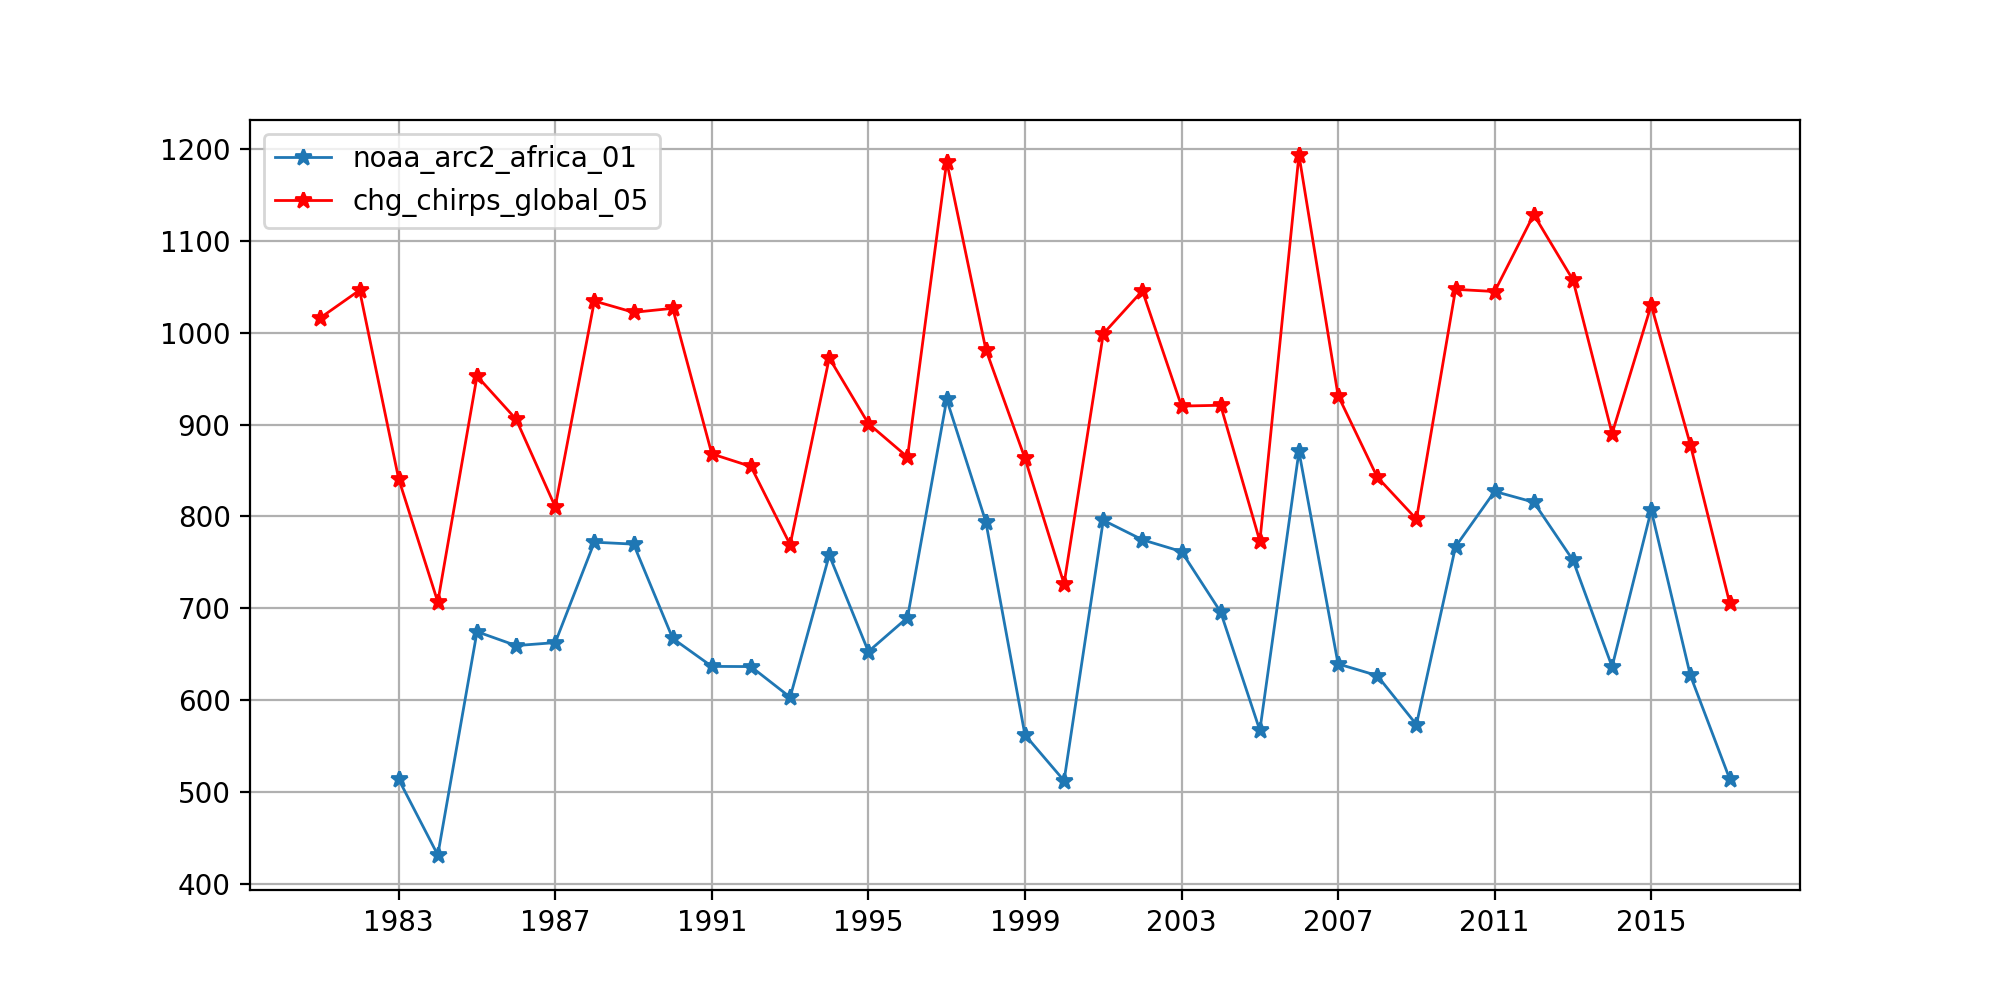

In [10]:
yearly_sum1 = dd1.pr.resample('1AS', dim='time', how='sum')
yearly_mean_sum1 = yearly_sum1.mean(axis=(1,2))

yearly_sum2 = dd2.precip.resample('1AS', dim='time', how='sum')
yearly_mean_sum2 = yearly_sum2.mean(axis=(1,2))

fig = plt.figure(figsize=(10,5))
plt.plot(yearly_mean_sum1.time,yearly_mean_sum1, '*-',linewidth = 1,label = dataset1)  
plt.plot(yearly_mean_sum2.time,yearly_mean_sum2, '*-',linewidth = 1,c='red',label = dataset2)
plt.legend()
plt.grid()
plt.show()

In the plot above, we used data from 1982, to show all the data from CHIRPS, now we want to limit the data to have the same time range for both datasets, so that we can compare them.

In [11]:
time_start = '1983-01-01T00:00:00'

dd2 = dd2.sel(time = slice(time_start,time_end))
dd2_dat = np.ma.masked_where(np.isnan(dd2.precip.data),dd2.precip.data)
dd2_dat = dd2.precip.data
dd1_dat = dd1.pr.data

Now, we will find out maximum precipitation over the whole period. And we will see that CHIRPS shows much higher values than ARC2. Differences between ARC2 and CHIRPS are brought out in __[CHIRPS Reality Checks document](http://wiki.chg.ucsb.edu/wiki/CHIRPS_Reality_Checks)__ as well. 

In [12]:
# maximum precipitation over the whole period
print ('\033[1mMaximum precipitation over the whole period \033[0m')
print(dataset1 + '\t' + str(np.nanmax(dd1_dat)))
print(dataset2 + '\t' + str(np.nanmax(dd2_dat)))

Maximum precipitation over the whole period 
noaa_arc2_africa_01	299.939575195
chg_chirps_global_05	573.563842773


In this section, we will find minimum, maximum and average number of dry days. Interestingly, CHIRPS and ARC2 datasets have very similar values for dry days. We can see that on average, there is 9912 - 10406 dry days in 34 years. Which is not that much, only about 27 days per year.  

In [13]:
dd1_dry_days = np.sum(np.where(dd1_dat>0.1,0,1),axis=0)
dd2_dry_days = np.sum(np.where(dd2_dat>0.1,0,1),axis=0)

# minimum, maximum and average nr of dry days
print ('\033[1mNumber of dry days:\tMinimum\t Maximum Average\033[0m')
print(dataset1 + '\t' + str(np.amin(dd1_dry_days)), '\t',str(np.amax(dd1_dry_days)),'\t',str(np.mean(dd1_dry_days)))
print(dataset2 + '\t' + str(np.amin(dd2_dry_days)),'\t',str(np.amax(dd2_dry_days)),'\t',str(np.mean(dd2_dry_days)))

Number of dry days:	Minimum	 Maximum Average
noaa_arc2_africa_01	5340 	 12276 	 9912.65272938
chg_chirps_global_05	6021 	 12139 	 10406.9352497


### Monthly averages over the period

Here we are comparing monthly averages using the violin plot at first and then bar plot for easier overview. 

In [14]:
##help(dd1.precip.resample)
dd1_monthly_avg = dd1.pr.resample('1MS', dim='time', how='sum')
dd2_monthly_avg = dd2.precip.resample('1MS', dim='time', how='sum')


In [15]:
mm_data1 = [];mm_data2 = []
for i in range(12):
    mmm1 = np.mean(dd1_monthly_avg[i::12,:,:],axis=0).values
    mm_data1.append(mmm1)
    
    mmm2 = np.mean(dd2_monthly_avg[i::12,:,:],axis=0).values
    mm_data2.append(mmm2)


In the violin plot below, we cas see that CHRIPS has very much bigger maximum values during  April, May and November. However, most of the months, ARC2 and CHIRPS mean values are quite similar. 

<IPython.core.display.Javascript object>


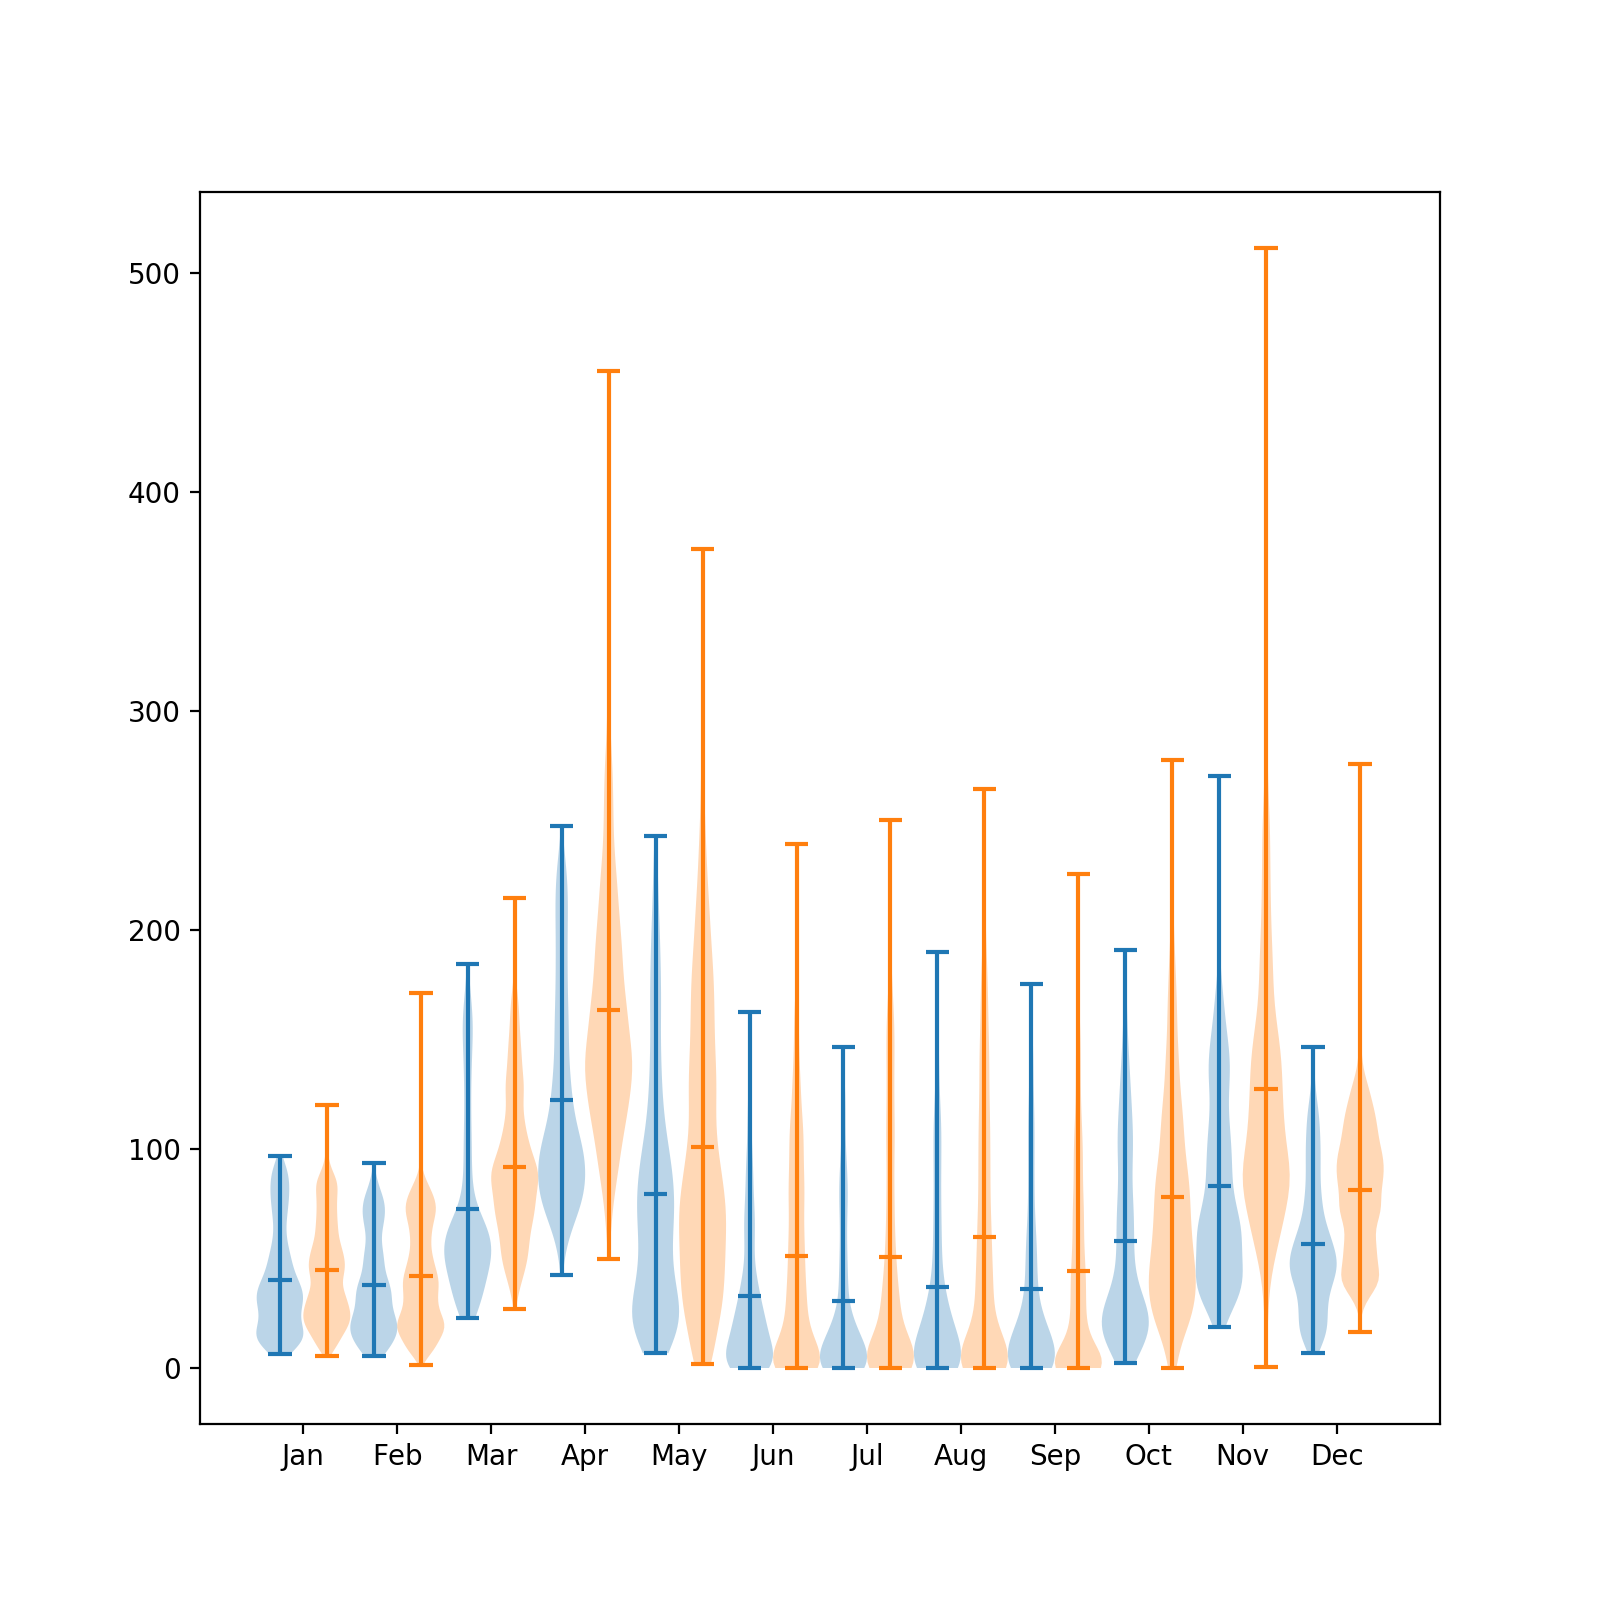

In [16]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.violinplot(mm_data1,np.arange(0.75,12.75,1),
                   showmeans=True,
                   showmedians=False)
ax.violinplot(mm_data2,np.arange(1.25,13.25,1),
                   showmeans=True,
                   showmedians=False)
plt.setp(ax, xticks = np.arange(1,13,1),
         xticklabels=[calendar.month_abbr[m] for m in np.arange(1,13,1)])

plt.show()

Now we show mean monthly values on bar plot as well. So it is easier to follow monthly averages. They are similar with both datasets, the biggest differences are on April and November, we saw same thing on the previous plot. 
But we can also see that the wettest month of the year is April and summer months are the driest. 

<IPython.core.display.Javascript object>


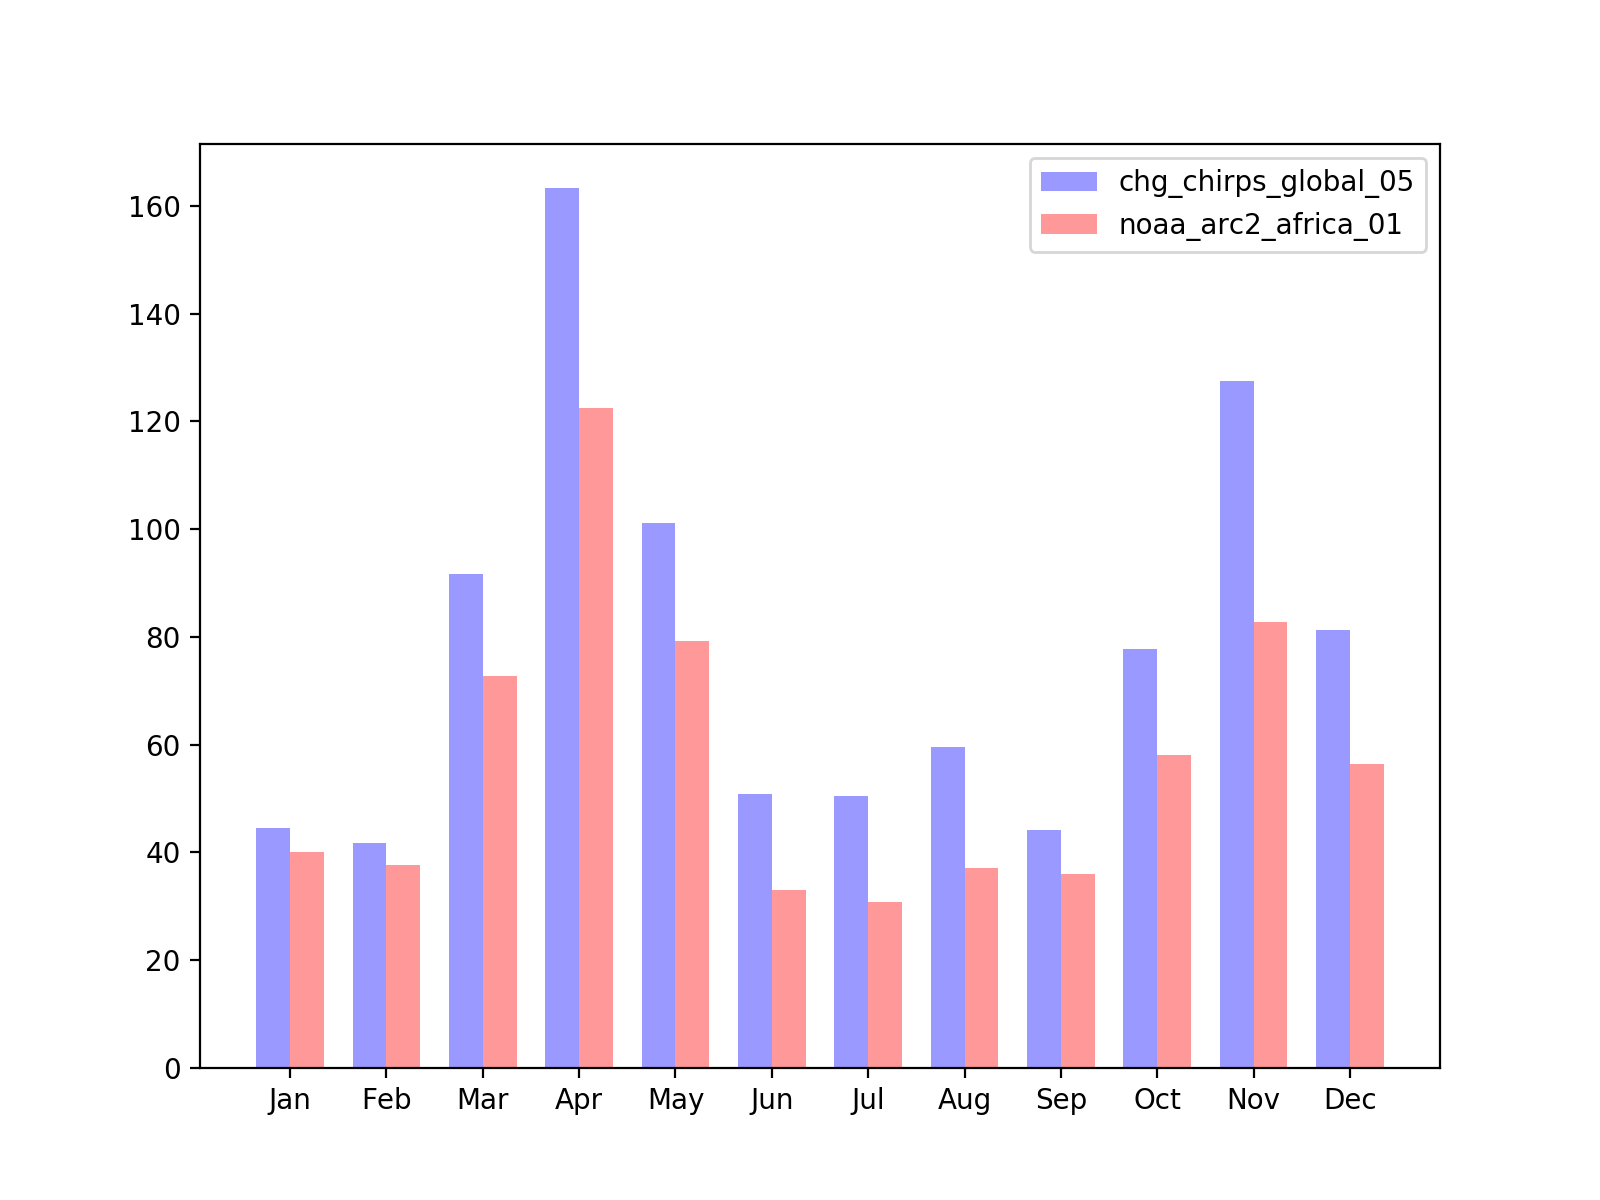

In [17]:
averaged_monthly_mean2 = np.mean(mm_data2,axis = (1,2))
averaged_monthly_mean1 = np.mean(mm_data1,axis = (1,2))


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

bar_width = 0.35
opacity = 0.4

ax.bar(np.arange(0,12,1)-bar_width/2,averaged_monthly_mean2,
    bar_width,
    alpha=opacity,
    color='b',
    label = dataset2)
       
ax.bar(np.arange(0,12,1) + bar_width/2,averaged_monthly_mean1,
       bar_width,
       alpha=opacity,
       color='r',
       label = dataset1)

plt.legend()
plt.setp(ax, xticks = np.arange(0,12,1),
         xticklabels=[calendar.month_abbr[m+1] for m in np.arange(0,12,1)])

plt.show()

Finally, let's see monthly anomalies for 2016. The period used for computing the climatology is 1983-2017. Positive values in the plot means that 2016 precipitation was above long term normal. Seems that April on 2016 had much precipitation in South-West Kenya. In the same time, October and December, which are short rain period, had less precipitation than normal. 

There has been serious droughts in Kenya during 2016, but it mostly covers Northern and South-East Kenya. World Weather Attribution has made __[2016 Kenya drought analyzes](https://wwa.climatecentral.org/analyses/kenya-drought-2016/)__ from where you can see that Sout-West area has had more precipitation as normal most of the time, but a little less since from June to December (except November).

In [18]:
time_start = '2016-01-01T00:00:00'
time_end = '2016-12-31T23:00:00'

dd2_2016 = dd2.sel(time = slice(time_start,time_end))
dd1_2016 = dd1.sel(time = slice(time_start,time_end))

In [19]:
dd1_monthly2016_avg = dd1_2016.pr.resample('1MS', dim='time', how='sum')
dd2_monthly2016_avg = dd2_2016.precip.resample('1MS', dim='time', how='sum')

<IPython.core.display.Javascript object>


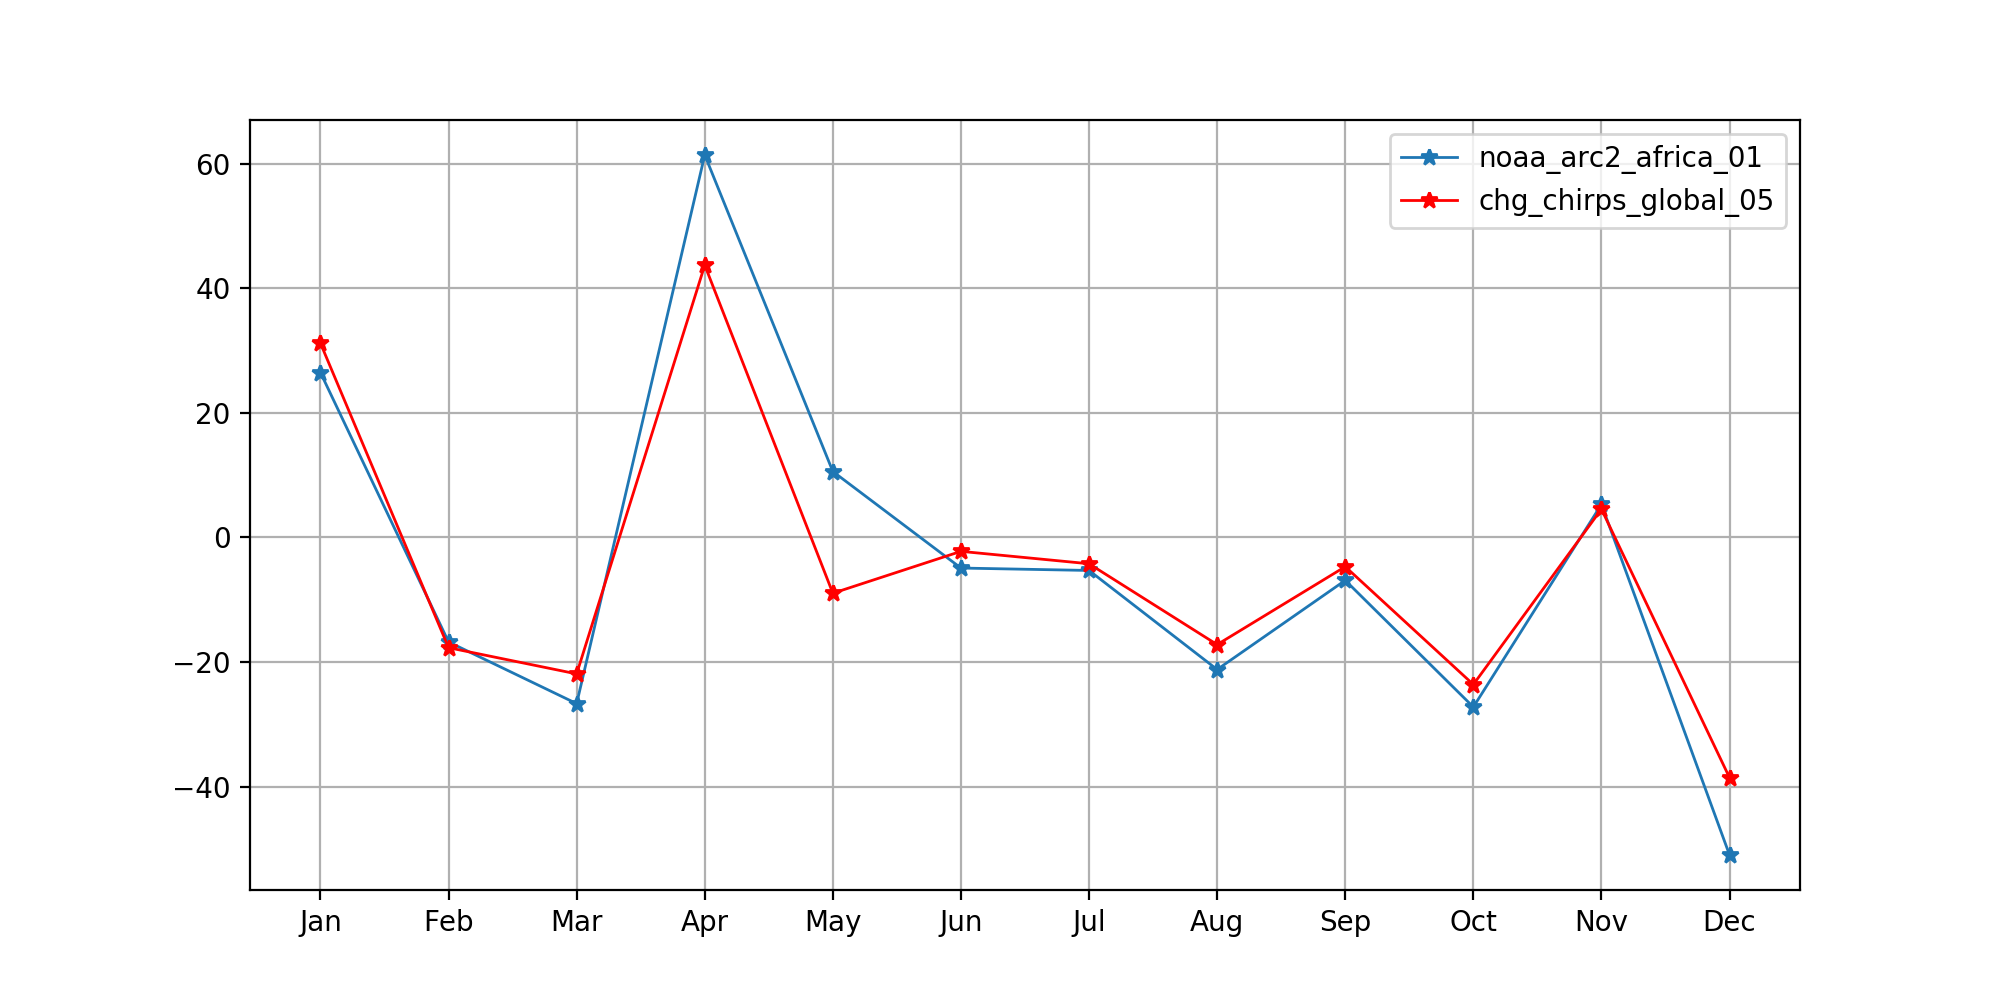

In [20]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(1,13,1),np.mean(dd2_monthly2016_avg,axis = (1,2))-averaged_monthly_mean2, '*-',linewidth = 1,label = dataset1)  
plt.plot(np.arange(1,13,1),np.mean(dd1_monthly2016_avg,axis = (1,2))-averaged_monthly_mean1, '*-',linewidth = 1,c='red',label = dataset2)

plt.setp(ax, xticks = np.arange(1,13,1),
         xticklabels=[calendar.month_abbr[m] for m in np.arange(1,13,1)])
plt.legend()
plt.grid()
plt.show()